In [60]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import cv2
import matplotlib.pyplot as plt

Let's start by getting the coordinates so that I can make a general map of Toronto

In [43]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="Tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


I also want to read in the table from the previous sections so that I can get the latitudes and longitudes of all the neighborhoods and boroughs.

In [44]:
Toronto = pd.read_csv('Toronto2.csv')
Toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Next, we can make a map of Toronto with all the neighborhoods

In [45]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

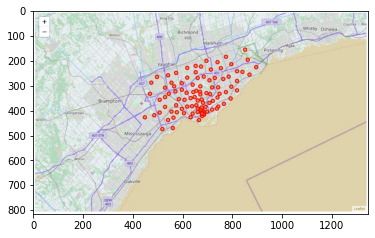

In [61]:
#The folium map won't load in github so I will read in a screen shot image here
img = cv2.imread('mapToronto.jpg') 
plt.imshow(img)

Now let's work with Foursquare to get more information about Toronto

In [ ]:
CLIENT_ID = 'OCXA0PM4Y33I15DA3AXJ35NRPFUGDMDBCRJ2WFOVFSQUEIBP' # your Foursquare ID
CLIENT_SECRET = 'CNIYB42DKRUIFWNAGFEEWZQOPLFLXXBO0VILJD2Q0PF5OG15' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

I'm going to define some functions as was done in the lab during the course.

In [47]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=10):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's get the names of all the neighborhoods and put them in a new dataframe.

In [49]:
toronto_venues = getNearbyVenues(names=Toronto['Neighborhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude'], 
                            
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

ConnectionError: HTTPSConnectionPool(host='api.foursquare.com', port=443): Max retries exceeded with url: /v2/venues/explore?&client_id=OCXA0PM4Y33I15DA3AXJ35NRPFUGDMDBCRJ2WFOVFSQUEIBP&client_secret=CNIYB42DKRUIFWNAGFEEWZQOPLFLXXBO0VILJD2Q0PF5OG15&v=20180605&ll=43.68641229999999,-79.4000493&radius=500&limit=10 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002754BA184C8>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))

In [50]:
print(toronto_venues.shape)
toronto_venues.head()

(691, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [51]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 179 uniques categories.


Next we need to do some one hot encoding

In [52]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Art Gallery,...,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,...,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Using a function to sort the venues in descending order

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Breakfast Spot,Latin American Restaurant,Lounge,Deli / Bodega,Dog Run,Distribution Center,Discount Store,Diner,Dessert Shop
1,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Skating Rink,Pub,Athletics & Sports,Gym,Dance Studio,College Stadium
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Deli / Bodega,Sandwich Place,Bridal Shop,Restaurant,Middle Eastern Restaurant,Bank,Ice Cream Shop,Sushi Restaurant,Women's Store
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Bank,Café,Women's Store,Deli / Bodega,Donut Shop,Dog Run,Distribution Center,Discount Store
4,"Bedford Park, Lawrence Manor East",Juice Bar,Comfort Food Restaurant,Coffee Shop,Italian Restaurant,Café,Thai Restaurant,Indian Restaurant,Sushi Restaurant,Restaurant,Pub


Now let's make five clusters using kmeans

In [56]:
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 3, 1, 3, 3, 1, 3, 1])

In [57]:
# add clustering labels
kmeans.labels_ = pd.DataFrame(kmeans.labels_)
neighborhoods_venues_sorted1 = pd.concat([neighborhoods_venues_sorted, kmeans.labels_], axis=1)
neighborhoods_venues_sorted1.rename(columns={0: "Clusters"}, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = pd.merge(Toronto,neighborhoods_venues_sorted1,on='Neighborhood')
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Clusters
0,M3A,North York,Parkwoods,43.753259,-79.329656,Park,Food & Drink Shop,Pool,Dog Run,Distribution Center,Discount Store,Diner,Dessert Shop,Department Store,Deli / Bodega,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,Coffee Shop,Hockey Arena,Pizza Place,Intersection,Portuguese Restaurant,Dog Run,Distribution Center,Discount Store,Diner,Dessert Shop,1
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Park,Historic Site,Coffee Shop,Distribution Center,Spa,Restaurant,Bakery,Pub,Breakfast Spot,Gym / Fitness Center,3
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Furniture / Home Store,Coffee Shop,Event Space,Boutique,Accessories Store,Vietnamese Restaurant,Comic Shop,Department Store,Donut Shop,3
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Coffee Shop,Arts & Crafts Store,Creperie,Distribution Center,Park,Italian Restaurant,Sushi Restaurant,Yoga Studio,French Restaurant,Cuban Restaurant,1


In [58]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

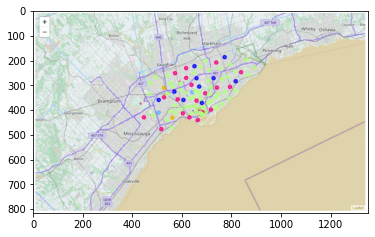

In [62]:
#The folium map won't load in github so I will read in a screen shot image here
img = cv2.imread('mapKmeans.jpg') 
plt.imshow(img)